In [70]:
import json
from jinja2 import Template
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
# 样例轨迹文件，经纬度
data = json.load(open('locations.json', encoding='utf-8'))

In [36]:
len(data), len(data[0]), len(data[0][0])

(220, 15, 2)

In [37]:
# 去除噪声数据一部分
data = data[90:200]

In [38]:
# 数据展平
result = []
for item in data:
    for sub_item in item:
        result.append(sub_item)
data = [result]

In [39]:
# 定义源模板文件，用于生成新的可视化文件
template = './template.tpl'
source = open(template, encoding='utf-8').read()

# 将路径数据、中心点数据替换到模板，生成结果
output = Template(source).render(data=data, center=[115.94716977692126, 28.211794684681426])

# 生成结果文件
output_file_path = 'preview.html'
with open(output_file_path, 'w', encoding='utf-8') as f:
    f.write(output)

## 高德地图显示结果

![](https://qiniu.cuiqingcai.com/2020-01-07-132356.png)

In [41]:
import numpy as np

In [42]:
data = np.asarray(data)

In [43]:
data.shape

(10277, 2)

In [44]:
data[0]

array([115.904883,  28.726181])

In [47]:
# 对数据进行放缩，经纬度放缩到一个 0-300 的区间
from sklearn.preprocessing import MinMaxScaler

In [48]:
mms = MinMaxScaler(feature_range=(0, 300))

In [49]:
mms.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 300))

In [52]:
data_scaled = mms.fit_transform(data)

In [53]:
data_scaled

array([[244.91020941, 243.17987471],
       [244.74616293, 243.24239258],
       [244.57838812, 243.3044793 ],
       ...,
       [ 20.54806438,   2.86547447],
       [ 20.41508731,   2.85642015],
       [ 20.27465358,   2.84995279]])

In [58]:
# 数据分割
from traj_cluster.partition import approximate_trajectory_partitioning, segment_mdl_comp, rdp_trajectory_partitioning
from traj_cluster.point import Point

In [61]:
# 转化成 Points 的集合
points = []
for x,y in data_scaled:
    point = Point(x, y)
    points.append(point)

In [62]:
len(points)

10277

In [63]:
traj = points

In [64]:
# 通过计算两个点之间存在 Partition 特征点时的 MDL 开销和不存在 Partition特征点时的开销
cost_par = segment_mdl_comp(traj, 0, 1, typed='par')
cost_nopar = segment_mdl_comp(traj, 0, 1, typed='nopar')

## 两种分割思路

* approximate_trajectory_partitioning：按照论文中的算法流程实现轨迹的partition部分, 主要通过MDL来确定特征点并实现的轨迹分段, 其中theta可以视为惩罚参数,若theta越大那么轨迹压缩率越大。
* rdp_trajectory_partitioning：实现轨迹压缩的Ramer-Douglas-Peucker算法, 实现对轨迹中的重要点进行提取并实现轨迹的分割, 和上面的partition方法的返回结果类似。

### approximate_trajectory_partitioning

In [82]:
# approximate_trajectory_partitioning 方法，theta 为 1.0
theta = 1.0
part = approximate_trajectory_partitioning(traj, theta=theta)

In [77]:
# 输入原路径 traj，分割后的结果 part，输出图片名，绘制原图和分割后的路段
def plot(traj, part, output_path):
    source_line_x = [p.x for p in traj]
    source_line_y = [p.y for p in traj]
    dest_line_x = []
    dest_line_y = []
    i = 0
    for s in part:
        if i == 0:
            dest_line_x.append(s.start.x)
            dest_line_y.append(s.start.y)
            dest_line_x.append(s.end.x)
            dest_line_y.append(s.end.y)
        else:
            dest_line_x.append(s.end.x)
            dest_line_y.append(s.end.y)
        i += 1
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.plot(source_line_x, source_line_y, 'g--', lw=2.0, label="trajectory")
    ax.scatter(source_line_x, source_line_y, alpha=0.5)
    ax.plot(dest_line_x, dest_line_y, lw=1.0, c='red', label="partition")
    ax.scatter(dest_line_x, dest_line_y, alpha=0.5)
    ax.legend()
    plt.savefig(output_path)
    plt.show()

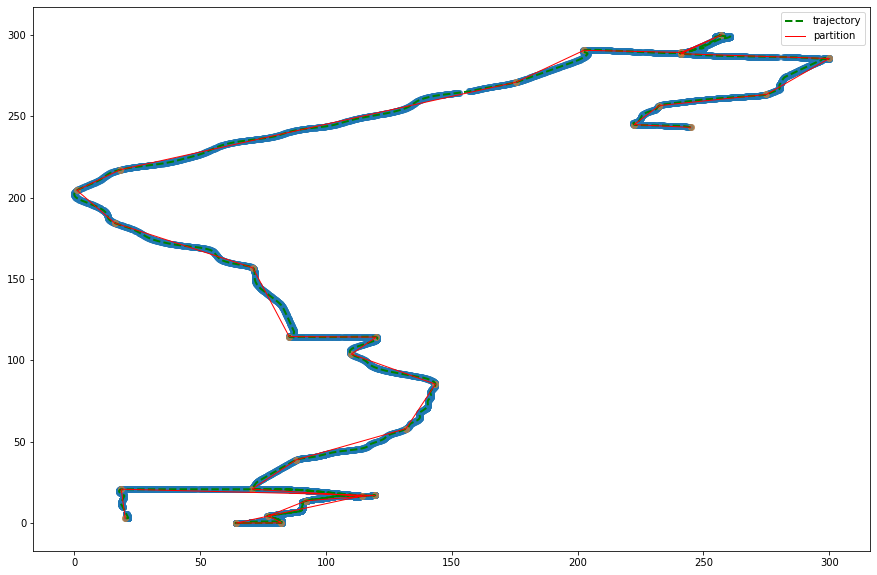

In [78]:
plot(traj, part, f'approximate_trajectory_partitioning_theta_{theta}.png')

### rdp_trajectory_partitioning

In [80]:
# rdp_trajectory_partitioning 方法，epsilon 为 1.0
epsilon = 1.0
part = rdp_trajectory_partitioning(traj, epsilon=epsilon)

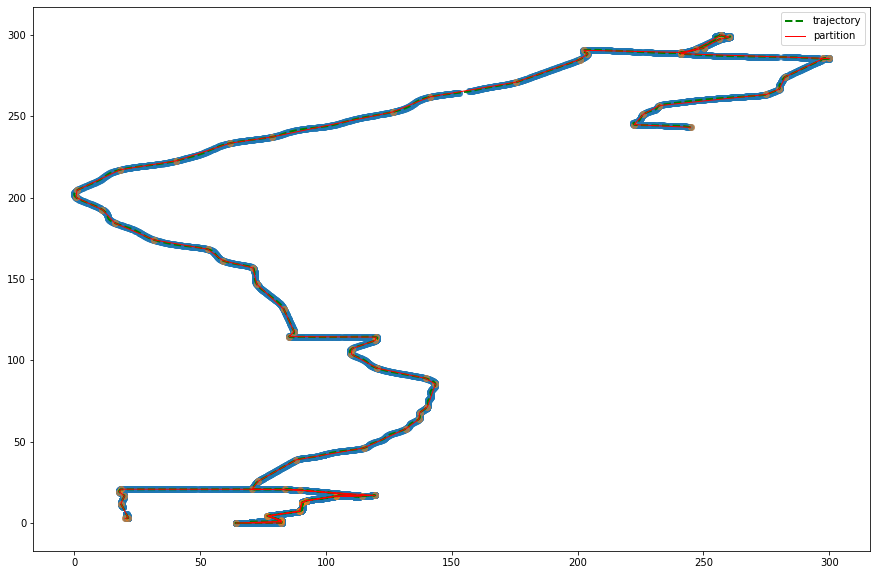

In [81]:
plot(traj, part, f'rdp_trajectory_partitioning_epsilon_{epsilon}.png')